In [1]:
# %matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

//miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('./dataset/test_basic.csv')

In [3]:
data.head()

,user_id,conversion,test
0,860955,0,0
1,911569,0,1
2,673989,0,0
3,562761,0,0
4,64288,0,0


user_id : the id of the user
conversion : this is the metric we care about in the test. In this case it is conversion. The goal of the test was to increase conversion rate
test : whether the user was in test (1) or control(0). If in test, they saw the new version of the site. Otherwise, they saw the old version

A/B Test

This table shows how test results are typically stored. Once you have the results in a table like that, all you need to do is usually running a t-test to check whether average conversion rate is significantly different for people who were exposed to the site change vs the others.
In practice, it would simply be something like this:


In [10]:
data.shape

(78943, 3)

In [4]:
#check conversion rate for both groups
print(data.groupby('test')['conversion'].mean())

test
0   0.044
1   0.056
Name: conversion, dtype: float64


In [5]:
print(data[data['test']== 1]['conversion'])

1        0
6        0
7        0
9        0
10       0
        ..
78932    0
78933    0
78934    1
78935    0
78937    0
Name: conversion, Length: 41512, dtype: int64


In [6]:
from scipy import stats
#perform a statistical test between the two groups
test = stats.ttest_ind(data.loc[data['test'] == 1]['conversion'], data.loc[data['test'] == 0]['conversion'], equal_var=False)

In [9]:
from scipy import stats
#perform a statistical test between the two groups, different way to code
test = stats.ttest_ind(data.query('test ==1').conversion, data.query('test ==0').conversion,equal_var=False)

In [10]:
print(test.statistic)

7.705449851546837


In [6]:
print(test.pvalue)

1.3189559402908635e-14


A test is winning if the test group is statistically significantly better. Statistical significance is usually assumed to be present if the p-value is <0.05. With regards to better, you need to make sure that the t-statistic is positive

If p-value were <0.05 and the t-statistic were negative, then test would be significantly worse than control

If p-value were > 0.05, then the difference between test and control would not be statistically significant


In [7]:
#print test results
if (test.pvalue>0.05):
  print ("Non-significant results")
elif (test.statistic>0):
  print ("Statistically better results")
else:
  print ("Statistically worse results")

Statistically better results


So in this case, the test is winning. Conversion rate is higher (from 4.3% to 5.5%) and the p-value is super low, suggesting us that that difference is extremely unlikely to be by chance. So we can be pretty confident that the new version is better and we should roll it out for all users.

A/B Testing Complexity

As we have seen, there are few things as simple as checking the test results once you have a clean table. The complexity in A/B testing comes from how to get to that clean table. There are several assumptions needed along the way in order for us to run the t-test. And we need to design the test in a way such that those assumptions are met. Namely:

Sample size: we have collected enough data to be able to detect a difference of at least the minimum amount we care about. For instance, if we had 10 users in test and 10 in control, the difference would never be statistically significant. So we need to make sure sample size is large enough

Randomization: we are assuming that two groups, test and control, are the same except for the new feature we are testing. So the difference we might see in conversion rate only depends on the new feature. This means that, for instance, the proportion of new users vs repeat users is the same, that proportion of users from US, UK, etc. is the same and so on. Basically, user distribution is the same across all variables that might impact conversion rate

Independency: we are assuming that events are independent. So we are assuming that what a certain user does, does not affect the behavior of another user. This is particularly hard to achieve in many of the most popular websites. After all, the best tech companies are those with network effects. And network effect implies that users are connected with each other. So it is non-trivial to design tests where users are actually independent from each other

Test result generalization: we are assuming that whatever we observe during the test can be generalized for all the population for an amount of time much longer than the test ran for. This is also not so straightforward. The most common case in which this is not true is novelty effect, but there are quite a few other cases. Novelty effect means that, when you show users a new feature, at first they will interact a lot with it mainly out of curiosity. Once curiosity wears off, they go back to their old behavior. So the new feature is not really better and will not deliver any long term gain despite the test winning, the opposite is change aversion, sometime user do not like changes, it takes some time for users to adjust changes.

Sample Size
 
The first step in designing an A/B test is figuring out for how long it should be run. That is, how many users do you need in your test? Or, rephrasing it in a statistical way, what’s the test sample size?

In the majority of cases, test sample size depends on 3 parameters:

Test significance level. This represents the probability to wrongly think that the new version is better than the old version. Obviously, the lower this number is, the better. A pretty common value for this is 0.05

Test power. This is the probability of correctly saying that the new version is better, when it is indeed better. 1-power is the probability of not making the change to the site, while you should have done it (being too conservative essentially). A common value for the power is 0.8. Obviously the higher, the better

Minimum effect you are interested in detecting: when you run a test, there is going to be a threshold below which, even if the test is winning, you won’t bother to make the change. Like if test is better than control by 0.000001%, you probably still won’t make the change, even if that difference were statistically significant. The engineering costs, time, and opportunity-cost in general, will make it useless to make a change to get that small of a gain. So the minimum effect defines what’s that threshold above which it makes sense to go ahead with the change

Sample size increases the smaller the significance level, the higher the power, and the smaller the minimum effect.

In practice, power and significance level are pretty much always 0.8 and 0.05. So what really affects sample size is the minimum effect.

Minimum effect is a business decision more than anything else, not really a data scientist decision. At work, it will typically be a product manager decision. After all, for that you need to take into account things like engineering costs, time, and opportunity-cost of not using those resources to run other tests. And that requires a comprehensive company vision which is typical of product managers, or VP/Director of product in smaller companies.

However, it is a data scientist job to let product people know for how long the test needs to be run based on their business requirements.

Sample Size Calculation

In the example below, we want to change our home page and the metric we are trying to improve is conversion rate from the home page to the second page in the funnel. Said it another way, we want to decrease the percentage of bouncers, i.e. people who come to the home page and then leave without doing anything. Let’s assume the current home-page to next-page conversion rate is 10%.

And let’s assume our product manager has told us that we only care about an improvement of at least +1%. Meaning, the new conversion rate for the test has to be at least 11%, up 1% from the 10% starting point. Otherwise, it is not going to be worth our time to even try the test and there are other stuff we could work on with higher potential.

Firstly, we need to define the two conversion rates via proportion_effectsize. 
The first element here (0.1) is simply the conversion rate of the site prior to running the test. Aka control conversion rate
The second one (0.11) is the minimum conversion rate of the test that would make it worth it to make the change

In [11]:
import statsmodels.stats.api as sms
p1_and_p2 = sms.proportion_effectsize(0.1, 0.11)
#Now we can run the function that after passing the two conversion rates above + power and significance, returns sample size
sample_size = sms.NormalIndPower().solve_power(p1_and_p2, power=0.8, alpha=0.05)
print("The required sample size per group is ~", round(sample_size))

The required sample size per group is ~ 14744


The output is pretty self-explanatory: this is telling us that we need ~15K in both test and control for us to be able to detect an increase of at least +1% in our metric.

Note that you can also pass a vector and see how sample size would change with different values for p2 (our test minimum conversion rate to make the change). You can then show that to the product manager to help them choose the best minimum effect. Something like this:

[0.105 0.11  0.115 0.12  0.125 0.13  0.135 0.14  0.145 0.15 ]


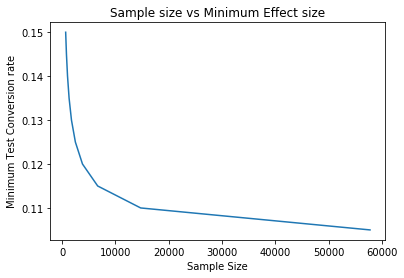

In [16]:
import numpy as np
import matplotlib.pyplot as plt
#Possible p2 values. We choose from 10.5% to 15% with 0.5% increments
possible_p2 = np.arange(.105, .155, .005)
print(possible_p2)
#now let's estimate sample size for all those values and plot them
sample_size = []
for i in possible_p2:
    p1_and_p2 = sms.proportion_effectsize(0.1, i)
    sample_size.append(sms.NormalIndPower().solve_power(p1_and_p2, power=0.8, alpha=0.05))
plt.plot(sample_size, possible_p2)
plt.title("Sample size vs Minimum Effect size")
plt.xlabel("Sample Size")
plt.ylabel("Minimum Test Conversion rate")
plt.show()

 Here you can see very well that, as we increase p2, the required sample size goes down quickly. It makes sense. 
 
 If we are looking for a very small gain, we need a lot of data to find it. But if we are looking for a huge gain like from 10% to 15% conversion rate, few data will be enough to check if that’s happening or not.
Finally, now that you know how many people you need in test and control, you can figure out for how many days you need to run the test based on your daily traffic.

A widely used approach to this is:

If you need more than 2 weeks to collect that many people, just split the traffic 50/50 and run it until you have the required sample size

Otherwise, still run it for two weeks to be able to reliably capture weekly patterns. But test it on the smallest percentage of users that would allow to collect enough data in 2 weeks

Example:
Let’s assume our site has 1K visitors per day. We found out we need ~15K users in both test and control to detect an improvement of at least +1%. So we would split the traffic 50/50 for test and control. Each day we would have 500 users in test and 500 in control. And we would run the test for 1 month, i.e. 30*500 = 15K

Let’s assume our site has 100K visitors per day. By splitting test and control 50/50, we would get all users we need in 1 day. But that would be too noisy, Sunday is different from Monday. And if we ran it for two weeks with a 50/50 split, we would collect way more data than we need. And that’s also not efficient, after all we could use that traffic to test other things. So we do something like this:

We want to have 15K people in two weeks. That means ~1K people per day. Since we have 100K daily visitors, 1% of our users will enter the test and see the different version of the site. Because of this, large companies typically run tests on 1% or less of their users